<!-- # Tutorial - Processing and Analysis of Zygo Surface Maps -->
## Demo - `ZygoMap` objects and how to use them

### Background

There are many scientific and engineering applications in which the thickness of bonds between two component's surfaces is an important factor. Particularly, this is highly relevant in designing Gravitational Wave detectors, where very small signals have to be differentiated from background noise sources - of which the bonds are major contributors. In fact, when building detectors a maximum peak-to-valley height of 60 nanometres is targeted for bonds between affixed components.

(See: `Cumming, A.V. et al. Classical and Quantum Gravity,
vol. 29/no. 3, (2012), pp. 035003.` https://doi.org/10.1088/0264-9381/29/3/035003)

The `Zygo` interferometer is a tool can be used to perform measurements of component surfaces. Along with proprietary software `MetroPro`, the maps of measurement data can be taken and stored in files for analysis.

This demo shows tools that have been implemented in Python to work with these output files, so that they can be analysed without requiring `MetroPro`. We can create and operate on them these maps using the `<ZygoMap>` class, simulate and compare their bonds using `combinemaps()` and `comparebonds()` functions. These are accessible via the `mapcompare.py` module.

## Let's Begin!
#### Imports

In [8]:
import matplotlib.pyplot as plt  # - plotting
import numpy as np  # - numpy arrays and variety of numerical manipulation
import pandas as pd  # - store data in frames for simple presentation
import scipy.ndimage  # - image/array rotation example

#set backend to allow interactive plotting
%matplotlib notebook

#import the ZygoMap class, and the combinemaps and comparebonds functions
from mapcompare import ZygoMap, combinemaps, comparebonds

### Example Workflow / Getting Started

To begin with, we need to provide and set up the data sources which we'd like to analyse.

`ZygoMap` objects are designed to work with specifically-formatted text files produced with `MetroPro` measurement software.
Information on the software and relevant formatting of files can be found in `MetroPro Reference Guide, Section 12, pgs 12-17`

(See: https://www.seas.upenn.edu/~nanosop/documents/MetroProReferenceGuide0347_M.pdf)

Six example files are provided locally in the `Zygo_textfiles` folder: `'A1.txt', 'A2.txt', 'C1.txt', 'C2.txt', 'M1.txt', and 'M2.txt'`.

Passing each filename into the ZygoMap class will process the data and create a map object to store the information and represent the surface measurements from the file as a 2D `numpy` array.

As we have multiple files to deal with, we can loop through and store all maps inside one list called `'zmaps'`. This will make it easier to maintain the maps, and to handle batch processing on all maps.

In [9]:
#6 example files stored in "Zygo_textfiles" folder:
file_path = "Zygo_textfiles/"
zfiles = ["A1.txt","A2.txt","C1.txt","C2.txt","M1.txt","M2.txt"]

#create a list to contain the maps
zmaps = []
for filename in zfiles:
    zmap = ZygoMap(file_path + "/" + filename)
    zmaps.append(zmap)
    
zmaps

Now the maps can all be kept in one container - however, there isn't an obvious way to identify the maps as shown above.

For this reason, each map is given its own `mapname` attribute so they can be identified. Users may set their own names when creating the object by supplying `mapname` as an argument; otherwise a default name is set - here, it is the stem of the filename without the `.txt` extension.

In [10]:
#full filenames can be awkward to ID each map,
#so the file's stem is taken as an easy identifier via the "mapname" attribute
[(m.filename, m.mapname) for m in zmaps]

[('Zygo_textfiles//A1.txt', 'A1'),
 ('Zygo_textfiles//A2.txt', 'A2'),
 ('Zygo_textfiles//C1.txt', 'C1'),
 ('Zygo_textfiles//C2.txt', 'C2'),
 ('Zygo_textfiles//M1.txt', 'M1'),
 ('Zygo_textfiles//M2.txt', 'M2')]

Using the `zmaps` list is simplest, however we can only pick out a map by its positional index in the list - e.g. `zmaps[0]` for the first map `A1`.

For this reason, it is helpful to construct a dictionary that links the mapnames to the maps:

In [11]:
#selecting maps can be made easier if we use a dictionary instead of a list
#clearly linking each map with its mapname
zmd = {m.mapname: m for m in zmaps}
zmd

{'A1': <mapobject.ZygoMap at 0x2431cc8ca30>,
 'A2': <mapobject.ZygoMap at 0x2431cc8ca00>,
 'C1': <mapobject.ZygoMap at 0x2431cc8cbb0>,
 'C2': <mapobject.ZygoMap at 0x2431cc8cca0>,
 'M1': <mapobject.ZygoMap at 0x2431cc8cd90>,
 'M2': <mapobject.ZygoMap at 0x2431cc8ce50>}

Now, selecting a map can be done explicitly and clearly:

In [12]:
zmd["A1"]

### Viewing Surface Maps & Properties

With the data successfully read in and stored, let's begin by understanding the properties each map has, and how they can be worked with.

We can examine or operate on the map objects with a few techniques:

<!-- #### print(`<ZygoMap>`) -->
#### Printing

Calling the Python `print()` function on a ZygoMap object outputs a simple description, giving the map's name, origin, as well as the two key metrics of the surface height values: the 'peak-to-valley' height, and the 'RMS' or 'root-mean-square' height.

In [13]:
#objects can be accessed with the name explicitly
#using print() we can obtain a simple description of the map
#this will tell us about the name and origin of the map (e.g. from file)
#and summarise the key metrics describing the map's surface
print(zmd["M1"])

ZygoMap object 'M1' for file: 'Zygo_textfiles//M1.txt'.
Peak-to-valley height: 105.2 nm
RMS height: 13.8 nm


#### Plotting

The main way of gaining an understanding of the map is through plotting the surface heights, so we can picture all the data at once.

`<ZygoMap>` comes with a built-in `plot()` method, that allows 2D (default) or 3D representation of the height data.

<IPython.core.display.Javascript object>


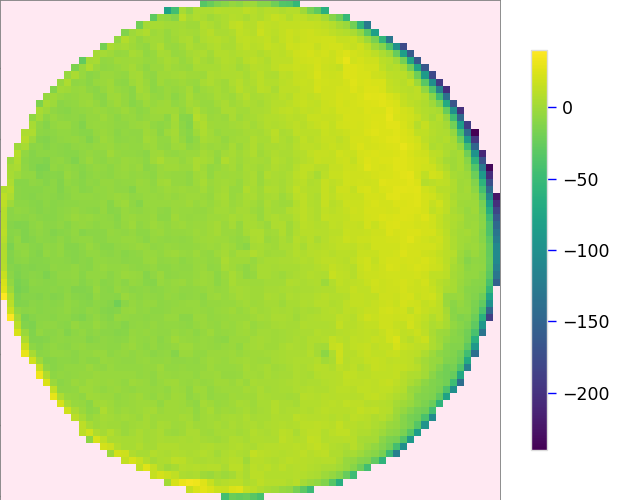

In [14]:
#let's initially examine the surface profile with a 2D plot of surface heights
zmd["C2"].plot()

Looking at the plot for `C2`, we can uncover some unexpected effects of this map. We see that most of the data appears to have very little variation, except for a small number of edge pixels.

A 3D plot could be helpful to illuminate the situation:

<IPython.core.display.Javascript object>


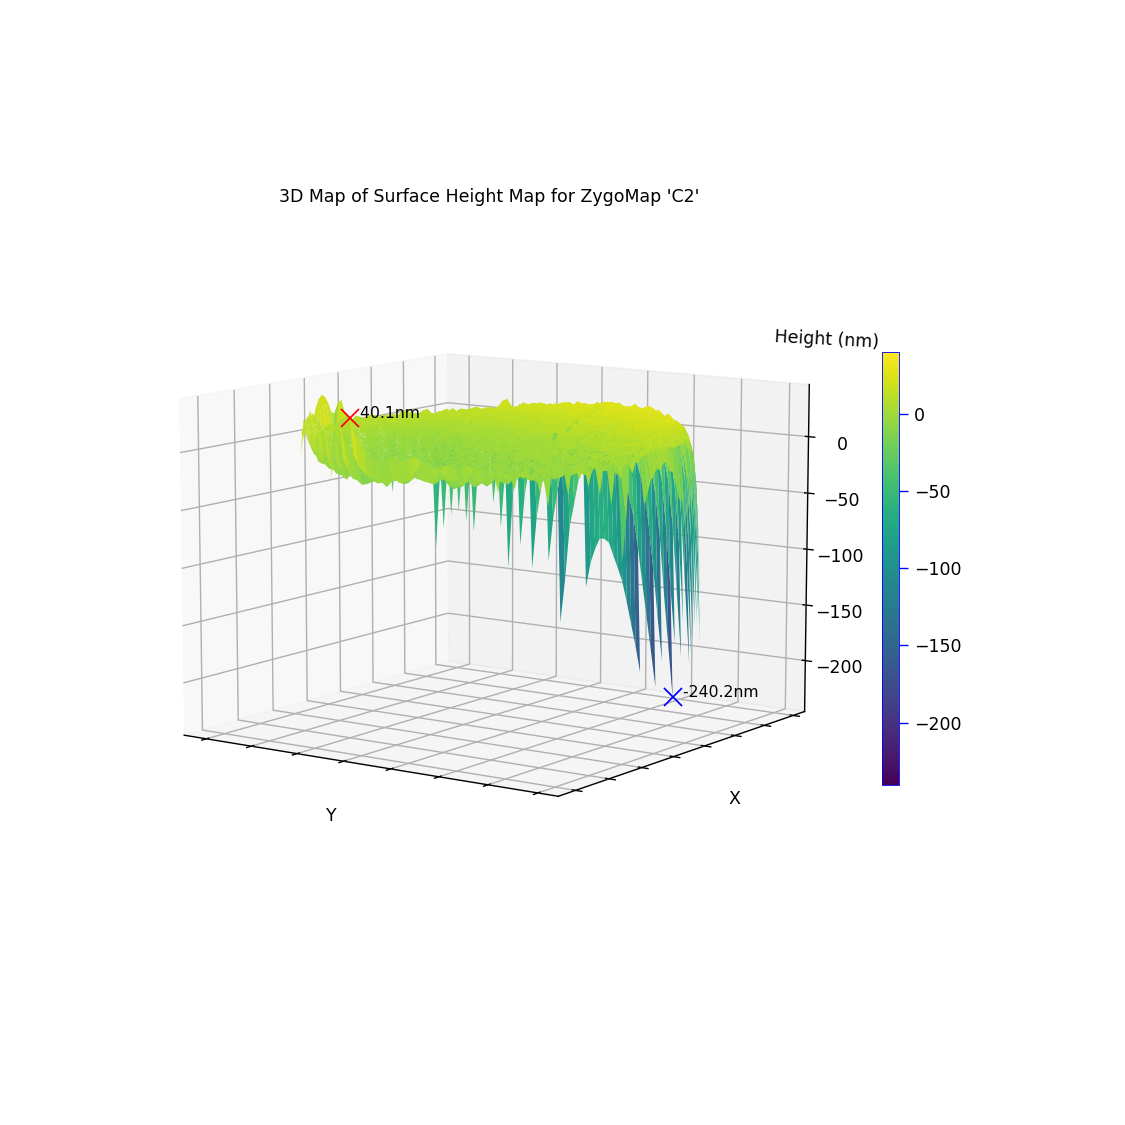

C:\Users\Scott\OneDrive\p4 project\mapobject.py:793: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  p = ax.plot_surface(x,y, array, vmin=valley, vmax=peak, cmap=current_cmap, ccount=10000, rcount=10000)


In [15]:
zmd["C2"].plot("3d")

The 3D plot clearly shows that `C2` is subject to large edge defects - the edge points are heavily dominating the majority of the data, and unbalance the scale so that we can't see the variation in the data.

Since these discontinuities appear only at the very edges, it is likely that these are diffraction effects that can arise during the measurement process (the `MetroPro` manual mentions this possibility). We can reasonably expect that the edge measurements are not representative of the true surface profile.

To gain a more informative representation of the surface, we need to consider removing the bad data. 

`ZygoMap` allows us to crop maps via the `crop()` method.

#### Cropping

Applying a crop to a map is a crucial step in the analysis, as it ensures we avoid results which are biased by bad data points, like in the case of `C2`.

We can use the `crop()` method of `<ZygoMap>` to define a chosen radius to crop the data to. We can give an exact radius from the centre as a positive number, or specify a relative trim inwards from the edge using a negative value.

Let's apply this to `C2` and see the difference from cropping:

<IPython.core.display.Javascript object>


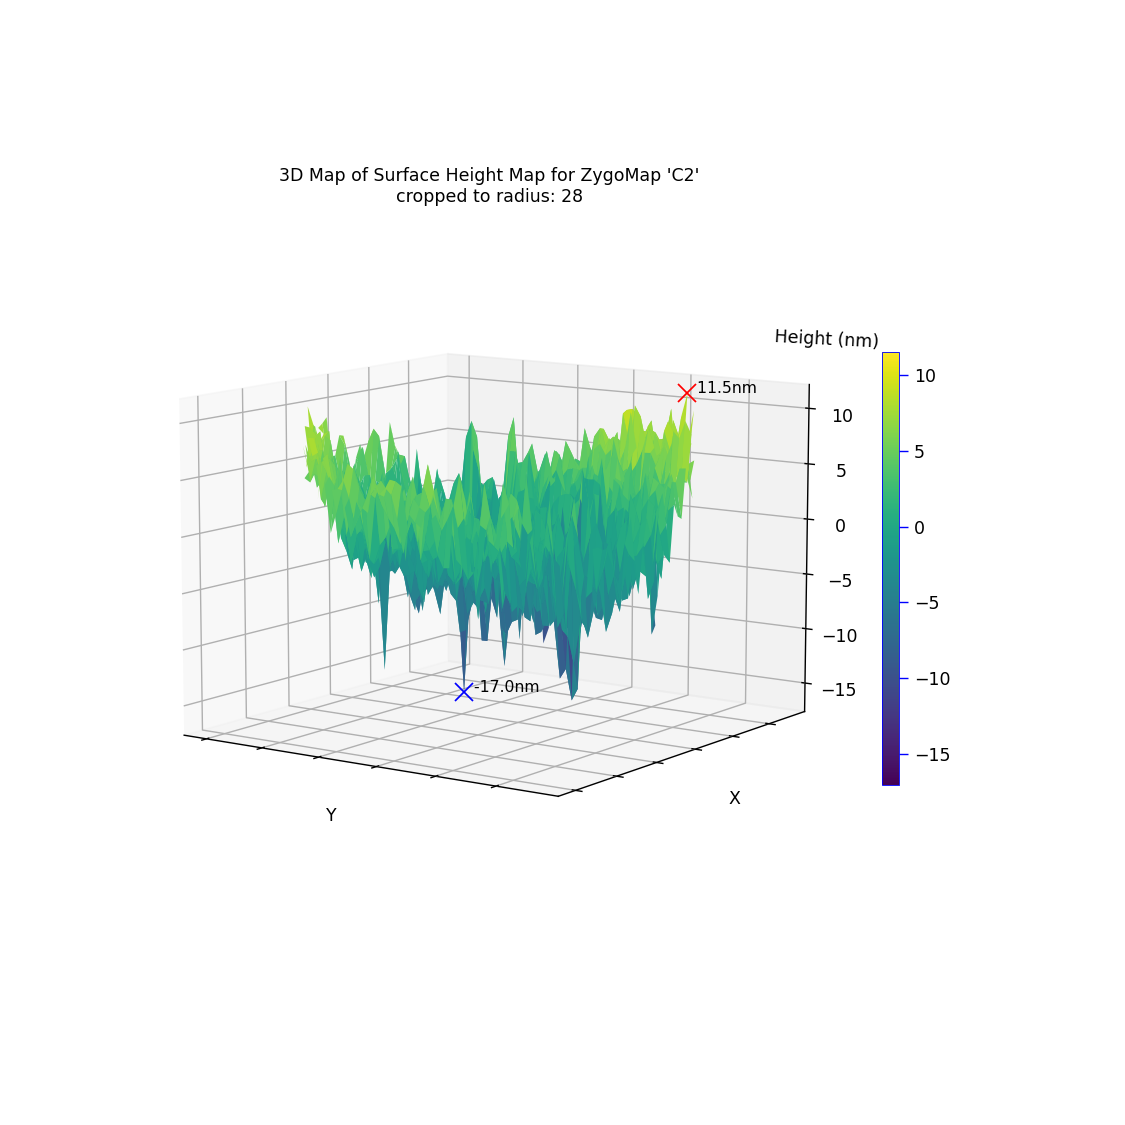

C:\Users\Scott\OneDrive\p4 project\mapobject.py:793: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  p = ax.plot_surface(x,y, array, vmin=valley, vmax=peak, cmap=current_cmap, ccount=10000, rcount=10000)


In [16]:
#cropping to radius 28 excludes the right-hand discontinuities
#as the original map had a radius of 35, a trim of 7 pixels gives a crop to radius 28
zmd["C2"].crop(-7).plot("3d")

<IPython.core.display.Javascript object>


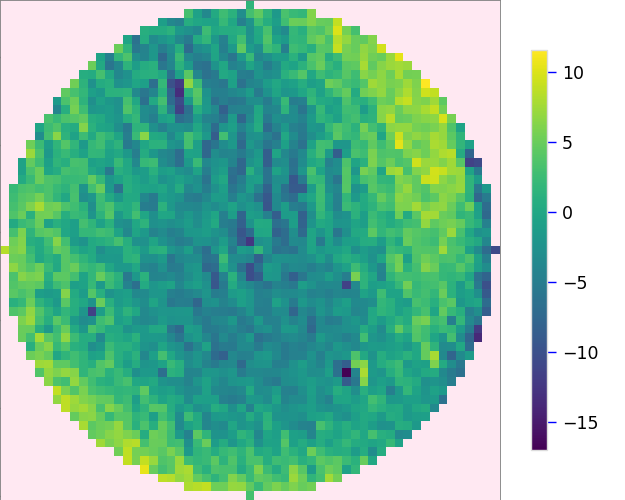

In [17]:
zmd["C2"].plot()

This is a much better picture now, as we can see clear variation where we didn't before.

Additionally, the peak-to-valley height has reduced from 280.3 nanometres to just 28.5 nanometres with only a small crop amount applied.

##### Important Note:
The application of `crop()` method does modify the state of the map object. It also returns the object, which allows us to chain commands, such as `<ZygoMap>.crop().plot()`. This choice makes quick analysis and experimentation with different values much easier to type, which is something that we want to be able to do.

As such, it is left to the user to keep track of the current state of their maps. 

We can check the current state by calling `print()` as before, which will tell us if the map is currently cropped and to what radius:

In [18]:
print(zmd["C2"])

ZygoMap object 'C2' for file: 'Zygo_textfiles//C2.txt'.
cropped to radius: 28
Peak-to-valley height: 28.6 nm
RMS height: 3.9 nm


Additional attributes are also available to be checked: the `is_cropped` flag is the simplest indicator; also, `r0` stores the original, uncropped radius as read-in, and `radius` tells us the current radius.

Luckily, it is very easy to return to the original state by simply calling `crop()` with no arguments. This will "reset" the map.

In [19]:
#the effect of crop() modifies the map's state
#so it is important to keep track of the current map size
#using "is_cropped" attribute,
#or by comparing if "radius" is equal to uncropped radius "r0"

#with crop of radius 20
zmd["C2"].crop(20)
print("Crop Applied:\n")
print("is_cropped: ", zmd["C2"].is_cropped)
print("r0 =", zmd["C2"].r0)
print("radius =", zmd["C2"].radius)
print("\n")

#reset the crop
zmd["C2"].crop()
print("No cropping:\n")
print("is_cropped: ", zmd["C2"].is_cropped)
print("r0 =", zmd["C2"].r0)
print("radius =", zmd["C2"].radius)

Crop Applied:

is_cropped:  True
r0 = 35
radius = 20


No cropping:

is_cropped:  False
r0 = 35
radius = 35


#### Interpolating / Grid-Scaling

Another functionality of `<ZygoMap>` is to interpolate the data over the grid defined by the array positions. This is useful to fill in points which may be missing values in the original data. Interpolation of values is performed upon reading in the data and before any other processing (cropping, tilt-removal) is applied.

<IPython.core.display.Javascript object>


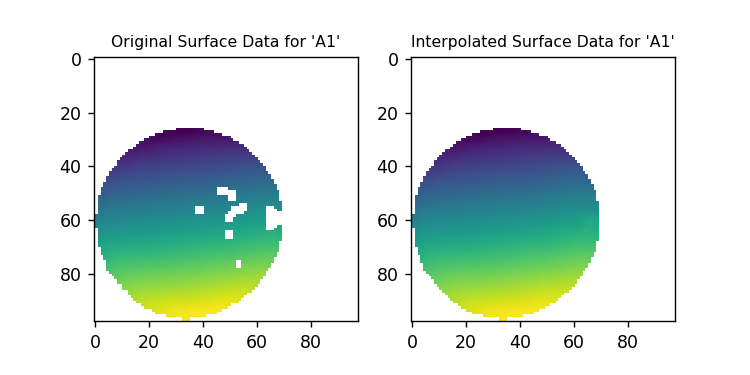

In [20]:
#the effect of interpolating to fill in missing data
#initial data stored in "heights0" attribute
#interpolated data stored in "heights1"
#main, updating data is stored in "heights"
fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(zmd["A1"].heights0)
ax[1].imshow(zmd["A1"].heights1)
ax[0].set_title("Original Surface Data for 'A1'", fontsize=9)
ax[1].set_title("Interpolated Surface Data for 'A1'", fontsize=9)
plt.show()

We can also use the same interpolation technique to re-fit the data to a new grid. If we supply a more dense grid, we can thus obtain a higher resolution upscaled copy of a map's `heights` array. The `interpolate_grid()` method of `<ZygoMap>` allows arguments `x_step` and `y_step` to define a new grid of points which the values are then fitted to.

##### Important Note:
Spatial changes in the grid would likely cause conflict/confusion with other properties of original data as read in. For this reason, in contrast to `crop`, `interpolate_grid` will not modify the `<ZygoMap>` object, but instead just return the new grid of values as an array.

It is suggested to create a new map manually for the upscaled data if the user wants to proceed with analysis on the higher-resolution data. Luckily, creating a new map in this way is fairly simple:

In [21]:
#heights interpolated with finer grid and stored in "C2_fine_grid"
C2_fine_grid = zmd["C2"].interpolate_grid(x_step=0.25, y_step=0.25)  # - returns array

#add the new object to storage dictionary/list while we're creating it
#as the array has no name data to use, we should provide a distinct mapname
new_name = "C2_upscaled"
zmd[new_name] = ZygoMap(array=C2_fine_grid, mapname=new_name)
zmaps.append(zmd[new_name])

In the interests of preserving data, the interpolated grid runs on the original, uncropped data by default. This means we should now specify a new crop for the upscaled data. 

Actually, this is something we should want to do anyway - the increase in resolution will allow more precision when finding a good crop radius.

<IPython.core.display.Javascript object>


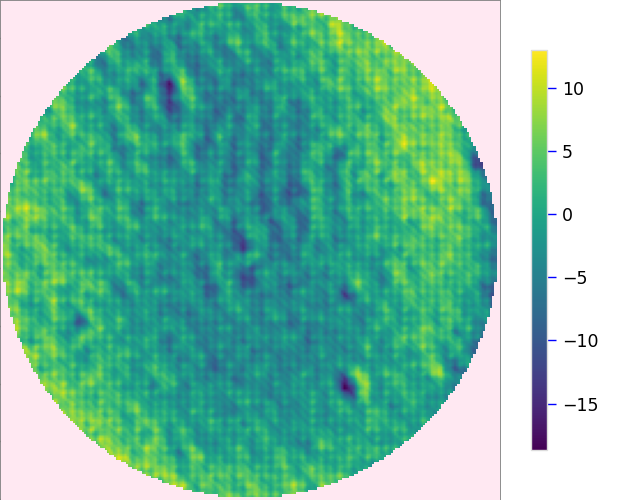

In [22]:
#use the full array, and re-adjust the crop now that we can be more precise
#reducing the edges by a trim of 30 pixels inwards gives similar profile
#now we have a smoother picture of the surface variation
#NOTE: it is not advisable to use interactive 3d plots with highly-upscaled maps
zmd["C2_upscaled"].crop(-30).plot("2d")

In [23]:
print(zmd["C2_upscaled"])

ZygoMap object for user-provided array 'C2_upscaled'.
cropped to radius: 108
Peak-to-valley height: 31.6 nm
RMS height: 3.9 nm


Great! Now we have a smoother picture of the surface variation.

### Simulating Bonded Surfaces - Combining Maps

Ultimately, the goal of our analysis is not just to inspect the surface maps but to inspect the bonds between maps when they are combined. We have been able to store multiple maps and view their surface profiles, and now we need a way to simulate their bonds.

Additional functions `combinemaps()` and `comparebonds()` will allow us to combine pairs of our stored `<ZygoMap>` objects and construct a new surface map of the bond interface between the two surfaces.

#### `combinemaps` Function

How do we go from separate maps of surfaces to a map of two bonded surfaces?

The bonds can be simulated by taking one map as the lower map and the other as the upper map. If the upper map is flipped downward, and its values negated, then this now emulates the relative orientations of the surfaces as they would physically be brought into contact to form a bond. The height gap between the surfaces when they first contact defines the interface which we are mapping.

In `combinemaps()`, the `heights` arrays can be added directly after flipping and negating the upper map. Any negative result is added back as an offset so that the surfaces are not intersecting in a non-physical manner.

The below figure illustrates the bonding process:

#### Visual example: Bonding Two Surfaces
<!-- ![Bonding Two Surfaces: Before](interface_before.png) -->
Before - Maps stored in original orientation | After - Upper map flipped downward. Faces brought into contact.
:- | :- 
![alt](interface_before.png) | ![alt](interface_after.png)

Using `combinemaps()`, we can supply a pair of maps whose bond we want to model, and the function will automatically create the interface as a `<ZygoMap>` object. Additionally, optimisation is performed for in-plane rotations of the upper map with respect to the lower map. The relative alignment of the two faces may be very infuential on the final bond parameters.

This concept is demonstrated by the below comparison for orientations of `'A1'`:

<IPython.core.display.Javascript object>


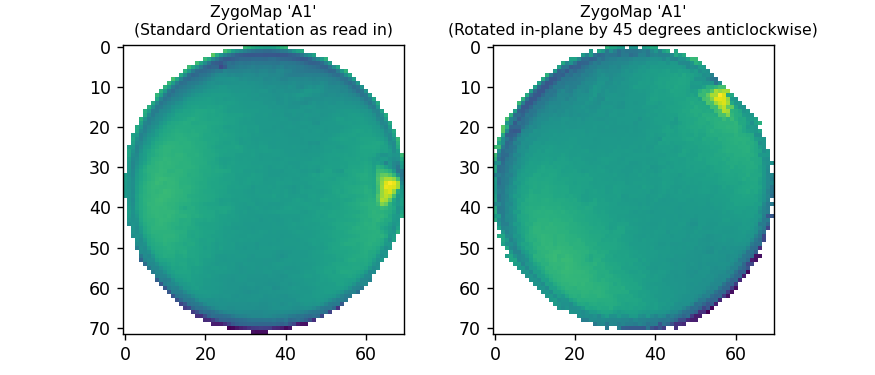

In [24]:
#clear visual example of the z-axis rotations used in combinemaps
#using "A1", with its distinct features,
C1_rot = scipy.ndimage.rotate(zmd["A1"].crop().heights, 45, order=0, reshape=False, mode="constant", cval=np.nan)

fig, ax = plt.subplots(1,2, figsize=(7,3))
ax[0].imshow(zmd["A1"].heights)
ax[1].imshow(C1_rot)

ax[0].set_title("ZygoMap 'A1'\n(Standard Orientation as read in)", fontsize=9)
ax[1].set_title("ZygoMap 'A1'\n(Rotated in-plane by 45 degrees anticlockwise)", fontsize=9)
plt.show()

It is clear that the orientation of the map could greatly affect the final peak-to-valley height of bond, such as maps being combined so that their peaks meet (a very unoptimised result).

So, `combinemaps` is also able to find the optimal rotation angle so that the peak-to-valley height can be minimised for the bond.

#### Interface / Bond Maps

Let's use `combinemaps` to create the optimised bond between `'C1'` and `'C2'`. The option is available to provide a custom `mapname` for the new map - this may be passed with the `newname` argument. Otherwise, `combinemaps` will default to merging the supplied map's names, joined with a "+".

A message will be printed out to show clearly the operation and results from `combinemaps` (this can be turned off with `output=False`).

In [25]:
#prepare maps with chosen crops
zmd["C1"].crop(32)
zmd["C2"].crop(28)

#combine the maps
iface = combinemaps(zmd["C2"], zmd["C1"], newname=None)

Combined interface map: 'C2+C1'
Maps combined for optimal angle of 111.00 degrees
'C1' clockwise w.r.t 'C2'
Optimised peak-to-valley height: 46.7 nm
Optimised RMS height: 8.6 nm


Good, the maps were combined to produce a new map. `combinemaps` returned a `<ZygoMap>` object called `'C1+C2'`, which is optimised when `'C1'` is rotated in-plane by 111$^{\circ}$, which gives a simulated peak-to-valley height of 46.7 nm.

We can inspect the interface map in the same way as individual maps. First, let's view a plot of the interface heights.

<IPython.core.display.Javascript object>


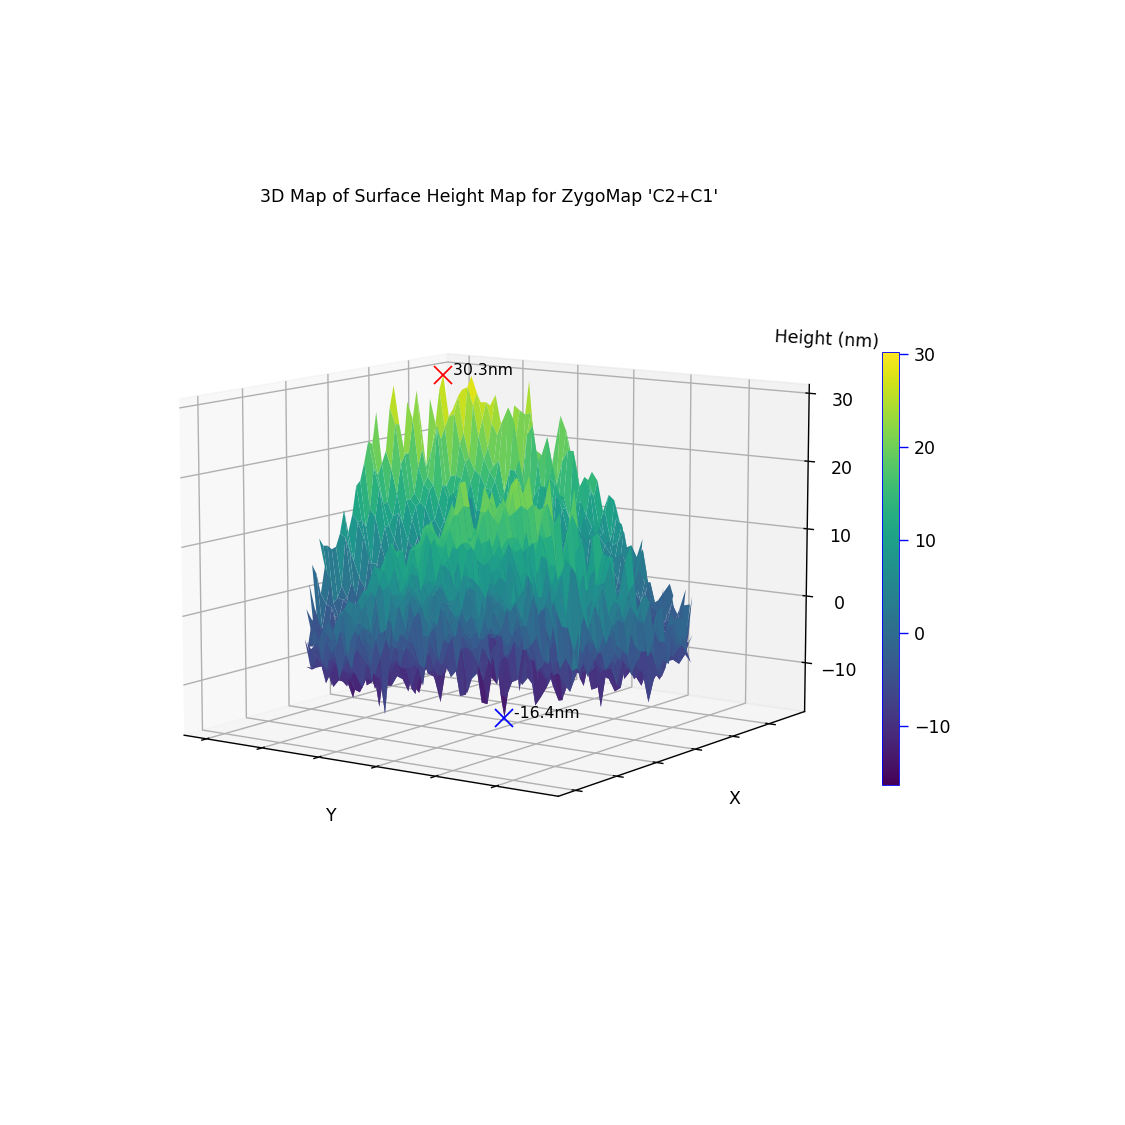

C:\Users\Scott\OneDrive\p4 project\mapobject.py:793: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  p = ax.plot_surface(x,y, array, vmin=valley, vmax=peak, cmap=current_cmap, ccount=10000, rcount=10000)


In [26]:
#inspect the profile of the interface
#the heights representing the gaps between the surfaces at the bond
iface.plot("3d")

The properties of interface maps are specified to show that the map represents a combination of maps rather than a single map. For example, `print()` will now reflect the creation from two other maps:

In [27]:
#in contrast to the maps produced directly from files, we can see how this map was made from the combination of "C2" and "C1"
print(iface)

ZygoMap interface object 'C2+C1' for 'C2' & 'C1' combined at angle 111.00 degrees.
Peak-to-valley height of bond: 46.7 nm
RMS height of bond: 8.6 nm


We can operate on the interface map just as we could with the individual maps, however we may want to revisit or make reference to the constituent maps and explore these further. References to the maps are stored in `map1` and `map2` attributes and, for simplicity, both can be accessed at once through the attribute `maps`.

In [28]:
#references to original maps are stored in the attributes "map1" and "map2"
#or, for ease-of-access, as a tuple (map1, map2) in the "maps" attribute
print((iface.map1.mapname, iface.map2.mapname))
iface.maps

('C2', 'C1')


(<mapobject.ZygoMap at 0x2431cc8cca0>, <mapobject.ZygoMap at 0x2431cc8cbb0>)

### Auto-comparison of simulated bonds

With multiple measured surfaces stored as `ZygoMap` objects, there are a large number of possible combinations if we want to study all possible bonds. For just the 6 example maps we are using, that already gives 15 possible pairs. Analysis will quickly become impractical if the user is expected to attend to creation and analysis of each map manually.

For comparison of bonds, we can run our maps through the `comparebonds()` function, which will find the possible combinations and create interface maps for each pair of maps. Each bond will be compared and sorted according to the lowest value of peak-to-valley, and all the maps are returned via a `pandas` `DataFrame` object which also contains the names of the constituent maps and the PV and RMS key metrics. We are then free to store the dataframe and the bond maps for any further use. We can also ask `comparebonds` to show plots of each bond's PV and RMS measurements - one sorted by smallest PV and another sorted in order of smallest RMS (turn on with `plot=True` option).

In [29]:
#need to supply a list/tuple/dict containing ZygoMap objects

#reset the dict to our original maps
zmd = {m.mapname: m for m in zmaps[:6]}

#pass in the dictionary (list or tuple also usable)
#store the output in a variable "sorted_bonds" for further access
sorted_bonds = comparebonds(zmd)

The 15 map combinations are returned as a dataframe from `comparebonds`. We should store this in `sorted_bonds` in case we need to access the data beyond this comparison. The interface/bond maps are accessible from the `'Bond Map'` column.

In [30]:
sorted_bonds

,Bond Map,mapname,map1,map2,PV,RMS
10,ZygoMap interface object 'C1+M1' for 'C1' & 'M...,C1+M1,C1,M1,2.562855e-08,3.824290e-09
5,ZygoMap interface object 'A2+C1' for 'A2' & 'C...,A2+C1,A2,C1,3.517001e-08,6.125371e-09
13,ZygoMap interface object 'C2+M2' for 'C2' & 'M...,C2+M2,C2,M2,3.757964e-08,6.002189e-09
2,ZygoMap interface object 'A1+C2' for 'A1' & 'C...,A1+C2,A1,C2,3.871719e-08,6.676767e-09
12,ZygoMap interface object 'C2+M1' for 'C2' & 'M...,C2+M1,C2,M1,4.493715e-08,7.540294e-09
9,ZygoMap interface object 'C1+C2' for 'C1' & 'C...,C1+C2,C1,C2,4.699668e-08,8.842019e-09
6,ZygoMap interface object 'A2+C2' for 'A2' & 'C...,A2+C2,A2,C2,5.060470e-08,9.716380e-09
11,ZygoMap interface object 'C1+M2' for 'C1' & 'M...,C1+M2,C1,M2,5.269731e-08,1.021981e-08
7,ZygoMap interface object 'A2+M1' for 'A2' & 'M...,A2+M1,A2,M1,7.416566e-08,8.448334e-09
14,ZygoMap interface object 'M1+M2' for 'M1' & 'M...,M1+M2,M1,M2,8.977204e-08,1.139849e-08


In [31]:
#extract all interface/bond maps
sorted_bonds["Bond Map"].values

array([<mapobject.ZygoMap object at 0x000002431E99AA30>,
       <mapobject.ZygoMap object at 0x000002431D52FFA0>], dtype=object)

In [32]:
#sorted by RMS height measurement rather than PV
sorted_bonds.sort_values(by="RMS")

,Bond Map,mapname,map1,map2,PV,RMS
10,ZygoMap interface object 'C1+M1' for 'C1' & 'M...,C1+M1,C1,M1,2.562855e-08,3.824290e-09
13,ZygoMap interface object 'C2+M2' for 'C2' & 'M...,C2+M2,C2,M2,3.757964e-08,6.002189e-09
5,ZygoMap interface object 'A2+C1' for 'A2' & 'C...,A2+C1,A2,C1,3.517001e-08,6.125371e-09
2,ZygoMap interface object 'A1+C2' for 'A1' & 'C...,A1+C2,A1,C2,3.871719e-08,6.676767e-09
12,ZygoMap interface object 'C2+M1' for 'C2' & 'M...,C2+M1,C2,M1,4.493715e-08,7.540294e-09
7,ZygoMap interface object 'A2+M1' for 'A2' & 'M...,A2+M1,A2,M1,7.416566e-08,8.448334e-09
9,ZygoMap interface object 'C1+C2' for 'C1' & 'C...,C1+C2,C1,C2,4.699668e-08,8.842019e-09
1,ZygoMap interface object 'A1+C1' for 'A1' & 'C...,A1+C1,A1,C1,1.099473e-07,8.956974e-09
3,ZygoMap interface object 'A1+M1' for 'A1' & 'M...,A1+M1,A1,M1,1.243896e-07,9.397014e-09
6,ZygoMap interface object 'A2+C2' for 'A2' & 'C...,A2+C2,A2,C2,5.060470e-08,9.716380e-09


Looking at the results, the bond between `'C1'` and `'M1'` gives the best results in terms of both PV and RMS metrics. Let's take a closer look at this bond.

In [33]:
#access specific rows with .iloc[index]
best_bond = sorted_bonds.iloc[0]["Bond Map"]
print(best_bond)

ZygoMap interface object 'C1+M1' for 'C1' & 'M1' combined at angle 19.50 degrees.
Peak-to-valley height of bond: 25.6 nm
RMS height of bond: 3.8 nm


<IPython.core.display.Javascript object>


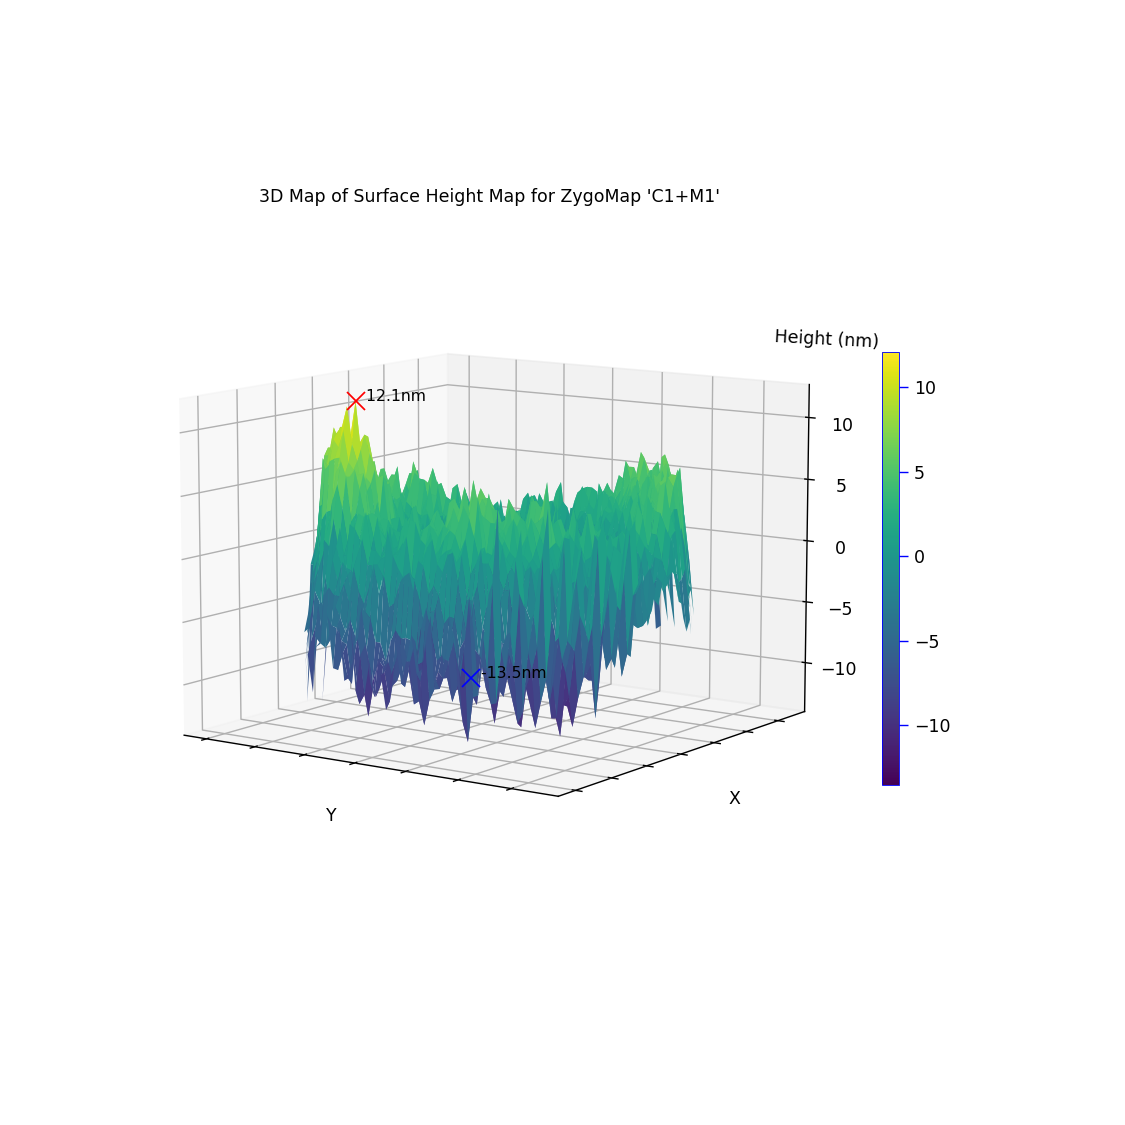

C:\Users\Scott\OneDrive\p4 project\mapobject.py:793: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  p = ax.plot_surface(x,y, array, vmin=valley, vmax=peak, cmap=current_cmap, ccount=10000, rcount=10000)


In [34]:
best_bond.plot("3d")

Our simulation of the bond has estimated a peak-to-valley height of 25.6 nm and RMS variation of 3.8 nm, when combining the maps at their optimal angle of 19.5$^\circ$.

However, it isn't immediately obvious how good or bad these measurements are without additional context. Plotting all the values should make clear where each bond performs compared to the rest. We could use the inbuilt plotting of `pandas` on the `sorted_bonds` frame, or return to `comparebonds` which has its own plotting style to highlight the 60 nanometre upper limit which is targeted in Gravitational Wave detector application (which was the initial motivation to compare bonds). 

(See: `Cumming, A.V. et al. Classical and Quantum Gravity,
vol. 29/no. 3, (2012), pp. 035003.` https://doi.org/10.1088/0264-9381/29/3/035003).

<IPython.core.display.Javascript object>


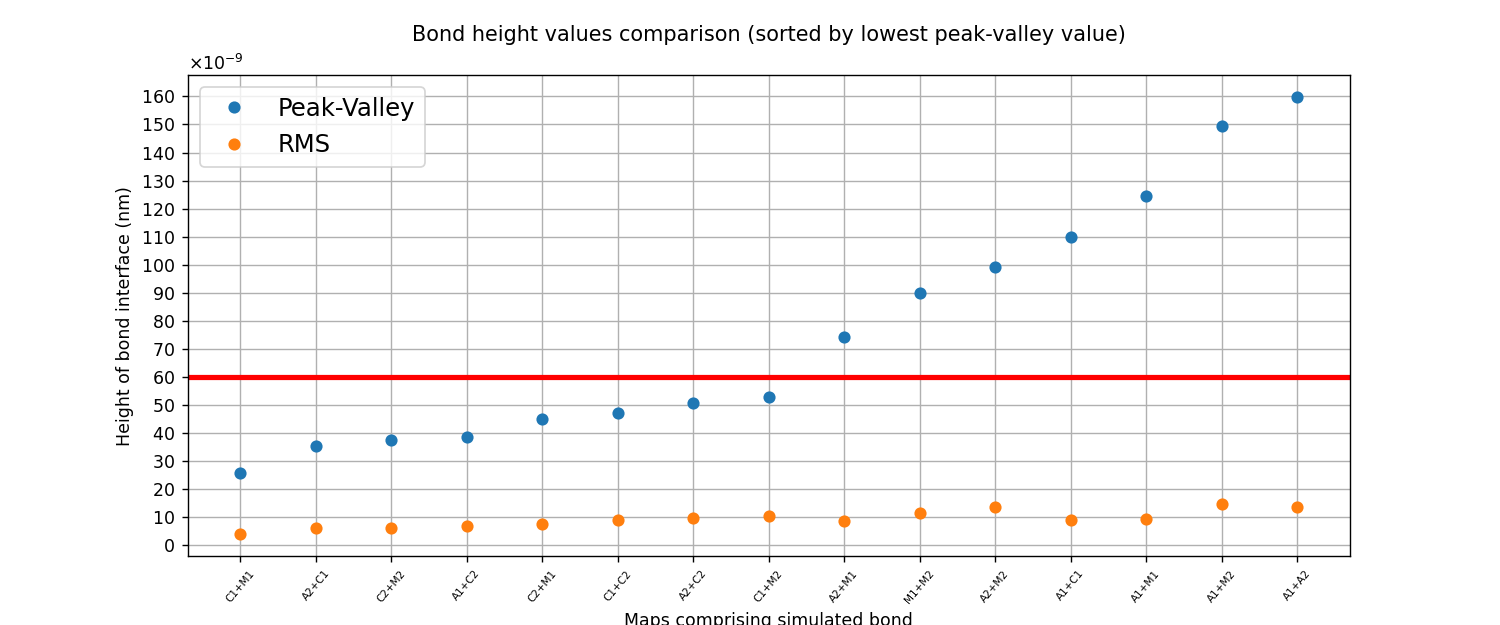

<IPython.core.display.Javascript object>


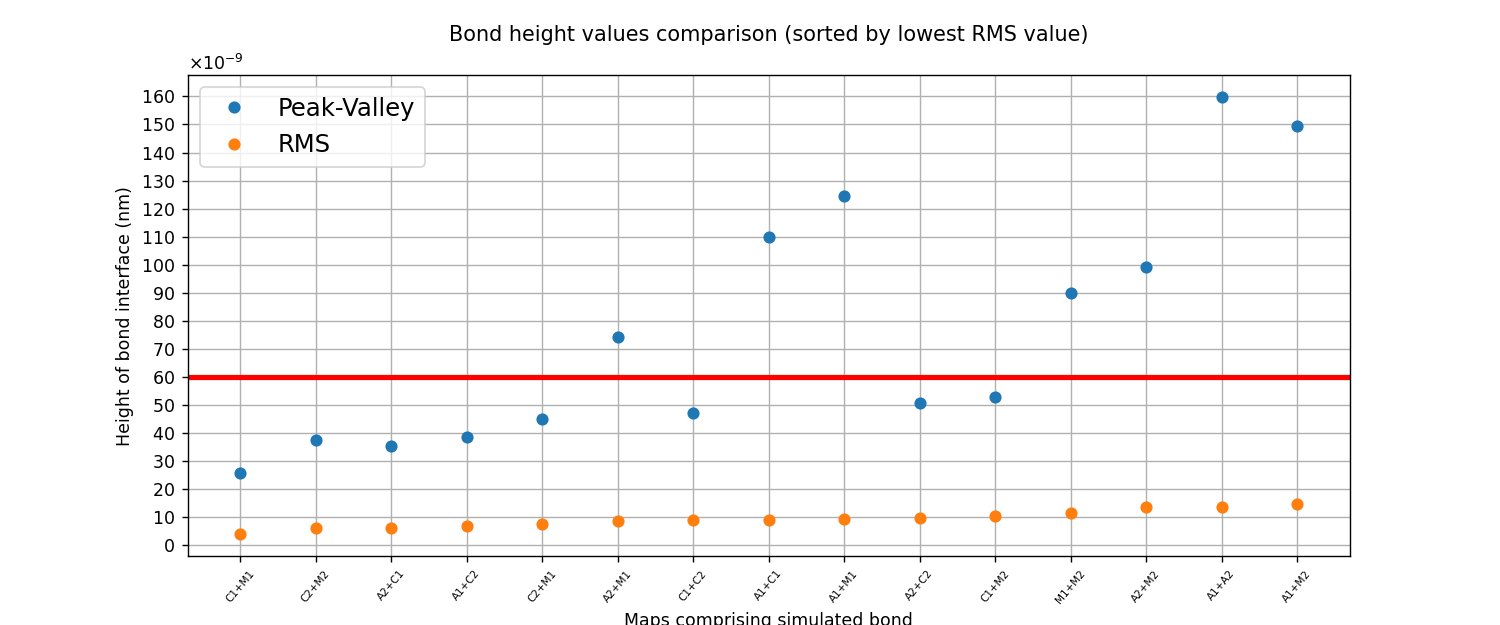

In [35]:
#if we wanted a simple visual comparison, set plot=True in comparebonds
#line at 60 nanometres highlights the upper limit for targeted peak-to-valley heights in Gravitational Wave detectors
#we can quickly pick out suitable map combinations
comparebonds(zmd, plot=True);

### The End ?

Great! Our work **can** be considered done.

However, we must be wary of taking the results at face value. As seen before, the effects of cropping can drastically change how the surface profiles appear. Thus, the state of each map will influence the final results. We should ensure that we are totally happy with our removal of defects and have cropped maps suitably before commencing bond comparisons.

An initial comparison using the uncropped base maps could be a helpful starting point to quickly determine which maps are outliers and likely need to be cropped. We can set up some simple automation to view how PV and RMS values change as the level of cropping increases:

In [36]:
#example of changing crop amount and subsequent effects
m = zmd["C2"]

#create a range of trim amounts (distance inward from edges)
#from no crop (0) to 24 pixels inward
trim_sizes = np.arange(0, -25, -1)

#storage for key metrics
pvValues = []
rmsValues = []

#apply crops and take measurements
for r in trim_sizes:
    cropped_z = m.crop(r)
    pvValues.append(cropped_z.peakvalley * 1e9)
    rmsValues.append(cropped_z.rms * 1e9)

m.crop() # - reset crop after

<IPython.core.display.Javascript object>


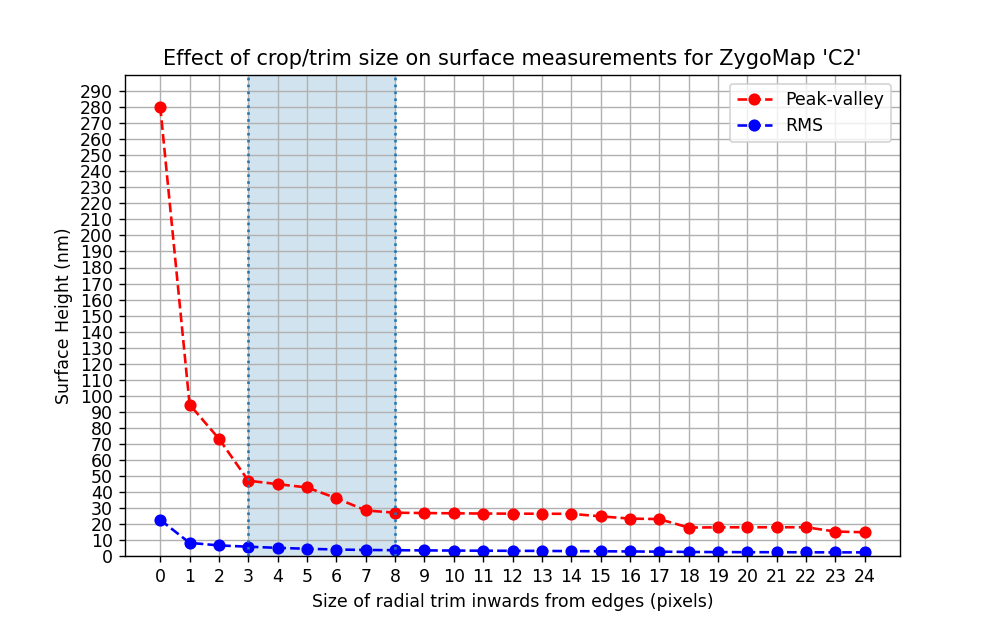

In [37]:
#create plot so we can see the values as cropping increases
plt.figure(figsize=(8,5))
plt.plot(abs(trim_sizes), pvValues, "ro--", label="Peak-valley")
plt.plot(abs(trim_sizes), rmsValues, "bo--", label="RMS")

plt.axvline(3, linestyle="dotted")
plt.axvline(8, linestyle="dotted")
plt.fill_between(x=range(3,9), y1=300, alpha=0.2)
plt.ylim(0, 300)

plt.yticks(np.arange(0, pvValues[0]+10,10))
plt.xticks(abs(trim_sizes))
plt.ticklabel_format(axis="y")

plt.xlabel("Size of radial trim inwards from edges (pixels)")
plt.ylabel("Surface Height (nm)")
plt.legend()
plt.grid()

plt.title("Effect of crop/trim size on surface measurements for ZygoMap '{}'".format(m.mapname))
plt.show()

The plot makes it clear that the majority of the reduction comes in the first few pixels - after that point we should have stable performance without edge defects. Thus, it suggests we should look for a crop amount of at least 3.

Looking at the values following a sharp gradient is our indicator of possible edge defects and where we should crop to remove them. We could supplement this by viewing the plots again if felt necessary - examination of `'C2'` seemed to suggest a trim of 8 edge pixels.